In [1]:
import itertools
import os
import time
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import logm, expm
from scipy.sparse.linalg import eigsh, svds
from pandas.plotting._matplotlib.style import get_standard_colors
colors = get_standard_colors(num_colors=13)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import ray
# 在初始化之前检查是否已经初始化
if not ray.is_initialized():
    ray.init()
else:
    # 如果已经初始化，可以选择关闭之前的 Ray 实例并重新初始化
    ray.shutdown()
    ray.init()


2024-02-04 13:00:21,679	INFO worker.py:1724 -- Started a local Ray instance.


## functions to generate dynamic SBM based on given changepoints 

In [2]:
from numpy import linalg as la

def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2   #计算矩阵A的对称部分B：B = (A + A.T) / 2，确保矩阵是对称的。
    _, s, V = la.svd(B) #对B进行奇异值分解（SVD）：_, s, V = la.svd(B)，其中_是一个占位符，s是奇异值向量，V是奇异向量矩阵。

    H = np.dot(V.T, np.dot(np.diag(s), V))  #通过奇异值和奇异向量重建半正定矩阵H：H = np.dot(V.T, np.dot(np.diag(s), V))。

    A2 = (B + H) / 2  #计算修正后的矩阵A2：A2 = (B + H) / 2。

    A3 = (A2 + A2.T) / 2  #再次确保A2是对称的：A3 = (A2 + A2.T) / 2。

    if isPD(A3):
        return A3
    #如果A3是正定矩阵，则返回A3。否则，通过调整矩阵元素的方式，逐步增加A3的最小特征值，直到成为正定矩阵。

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3


def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False
    
    ''' 函数isPD(B)用于检查矩阵B是否为正定矩阵。它使用Cholesky分解，尝试对矩阵进行分解，如果成功，则认为矩阵是正定的；
    否则，认为矩阵不是正定的。Cholesky分解是一种有效的方法，但仅适用于正定矩阵。
    这段代码的实现是对John D'Errico的MATLAB代码的Python/Numpy移植，原始MATLAB代码的参考文献也包含在注释中。 '''


In [3]:
'''这段代码实现了一个用于生成随机块模型（Stochastic Block Model，SBM）参数的函数create_SBM_parameters。
SBM是一种用于描述图的概率模型，其中图中的节点被分组成若干块，每两个节点之间的连接概率取决于它们所属的块。'''

def create_SBM_parameters(n=50, p11=0.25, p12=0.05, minimum_average_node_per_block=5):
    #定义函数create_SBM_parameters，它接受四个参数：节点数n（默认为50）、块内连接概率p11（默认为0.25）、块间连接概率p12（默认为0.05）
    #以及每个块的最小平均节点数minimum_average_node_per_block（默认为5）
    
    num_blocks = 2 ** np.arange(np.log(n // minimum_average_node_per_block) / np.log(2))
    num_blocks = num_blocks.astype(int)
    size_prob_parameters = []
    #计算块的数量num_blocks，这里使用了二进制对数的技巧，以确保每个块至少有minimum_average_node_per_block个节点。
    
    for n_block in num_blocks:
        sizes = [n // n_block] * (n_block - 1)
        sizes.append(n - sum(sizes))
        p = (p11 - p12) * np.eye(n_block) + p12 * np.ones((n_block, n_block))
        size_prob_parameters.append([sizes, p])    
    return size_prob_parameters
    '''遍历每个块的数量n_block，对于每个块：
    计算每个块的大小，使得均匀分布节点，确保最后一个块的大小充满剩余的节点。
    构建块内连接概率矩阵p，其中对角线上的元素为(p11 - p12)，其余元素为p12。
    将块的大小和连接概率矩阵作为参数，形成一个列表[sizes, p]，将其添加到size_prob_parameters列表中。'''

# 这个函数的作用是通过混合两个连续网络的边，生成一个在一定程度上反映两个网络结构的快照。
# 参数alpha控制了在混合中对新旧图的权重，使得生成的快照可以在两个网络之间平滑过渡。

def generate_snapshot_on_consecutive_networks(G_old, G_new, alpha=0):
    if alpha == 0:
        return G_old
    if alpha == 1:
        return G_new
    return nx.from_edgelist([edge for u, edge in zip(np.random.rand(G_old.number_of_edges()), nx.to_edgelist(G_old)) if u < alpha] + \
                            [edge for u, edge in zip(np.random.rand(G_new.number_of_edges()), nx.to_edgelist(G_new)) if u > alpha])
'''如果alpha的值为0，表示完全采用旧图G_old，则直接返回G_old。
   如果alpha的值为1，表示完全采用新图G_new，则直接返回G_new。
   对于0 < alpha < 1 的情况，生成一个混合图。使用np.random.rand生成相同数量的随机值，然后将这些随机值与边列表进行比较，
     根据比较结果决定保留哪些边。具体操作：对于G_old，保留随机值小于alpha的边。对于G_new，保留随机值大于alpha的边。
   最终将保留的边列表作为参数，使用nx.from_edgelist构建并返回一个新图。'''


'如果alpha的值为0，表示完全采用旧图G_old，则直接返回G_old。\n   如果alpha的值为1，表示完全采用新图G_new，则直接返回G_new。\n   对于0 < alpha < 1 的情况，生成一个混合图。使用np.random.rand生成相同数量的随机值，然后将这些随机值与边列表进行比较，\n     根据比较结果决定保留哪些边。具体操作：对于G_old，保留随机值小于alpha的边。对于G_new，保留随机值大于alpha的边。\n   最终将保留的边列表作为参数，使用nx.from_edgelist构建并返回一个新图。'

In [4]:
'''这段代码是用于生成动态随机块模型（Dynamic Stochastic Block Model，DSBM）的函数。
此函数生成一个包含多个时间步的动态随机块模型，其中每个时间步都对应一个随机块模型网络。
变化点用于指示网络结构发生变化的时间步。函数通过调用 stochastic_block_model 生成每个时间步的随机块模型，
并通过 generate_snapshot_on_consecutive_networks 函数在相邻时间步之间生成网络快照。'''

def generate_dynamic_SBM(T=100, cps=None, n=50, p11=0.25, p12=0.05, alpha=0, directed=False):
    # T: 时间步数，表示生成动态随机块模型的总时长
    # cps: 变化点的时间步列表，表示在这些时间步发生网络结构变化。
    # n: 节点数量
    # p11: 在同一社区内节点之间的连接概率
    # p12: 不同社区之间节点之间的连接概率
    # alpha: 动态性参数，控制相邻时间步网络之间的连接关系
    # directed: 是否为有向图
    
    if cps is None:
        cps = [T//2]   # 如果未提供变化点时间步列表，则默认在总时长的一半处发生一次变化
    cps.sort()         # 将变化点时间步列表排序
    cp_counter = 0     # 计数变量，用于跟踪当前变化点的位置
    G_prev = None
    G_curr = None
    # 上一时间步和当前时间步的网络
    G_list = []        # 保存生成的网络的列表
    size_prob_parameters = create_SBM_parameters(n, p11, p12)   # 创建节点大小和连接概率的参数列表
    size_prob_index_prev = None                                 
    size_prob_index_curr = np.random.choice(len(size_prob_parameters))
    # 上一时间步和当前时间步的节点大小和连接概率的索引
    
# 生成动态随机块模型的主循环
    for t in range(T): 
        cp = False
        if cp_counter < len(cps) and t == cps[cp_counter]:
            cp = True
            if size_prob_index_prev is None:
                size_prob_index_prev = size_prob_index_curr
            while size_prob_index_curr == size_prob_index_prev:
                size_prob_index_curr = np.random.choice(len(size_prob_parameters))
            cp_counter += 1
     # 检查是否在当前时间步有变化点
        
        sizes, p = size_prob_parameters[size_prob_index_curr]     # 获取当前时间步的节点大小和连接概率
        G_curr = nx.stochastic_block_model(sizes, p, directed=directed)    # 生成当前时间步的随机块模型网络
        if G_prev is not None and cp == False:
            G_curr = generate_snapshot_on_consecutive_networks(G_prev, G_curr, alpha)
        # 如果不是第一时间步且当前时间步没有变化点，则根据动态性参数生成网络快照
        G_list.append(G_curr)    # 将当前时间步生成的网络添加到列表中
        G_prev = G_curr          # 更新上一时间步的网络为当前时间步的网络
    
    return G_list, cps           # 返回生成的网络列表和变化点时间步列表

## Fréchet Change Detection Binary Segmentation Algorithm

In [5]:
# 该类的主要功能是检测网络图快照序列中的多个变化点。它使用了Fréchet测试和二分法进行变化点检测。

class ChangePointDetector:
    def __init__(self, G_list, c=2, epsilon=1e-2, B=100, m=100, alpha=0.05):
        """Detect multiple change points in a sequence of graph snapshots
        Parameters
        ----------
        G_list : `list`, len=(n_snapshots)
            List of networkx graphs.
        c : `int` or `float`, default=2
            Change points do not exist in the first and last few graphs in a sequence.
        epsilon: `float`, default=0.01
            The positive eigenvalue used to replace the zero eigenvalues of a Laplacian.
        B: `int`, default=100
            Bootstrap sample size
        m: `int`, default=100
            Length of each bootstrap sample
        alpha: `float`, default=0.05
            Significance level
        Returns
        -------
        """        
        # G_list : `list`, len=(n_snapshots) 包含网络图的列表，每个元素是一个 networkx 图。
        # c : `int` 或 `float`, 默认值=2，序列中的第一个和最后几个图中不存在变化点。
        # epsilon: `float`, 默认值=0.01， 用于替换拉普拉斯矩阵中零特征值的正特征值。
        # B: `int`, 默认值=100，Bootstrap 样本大小。
        # m: `int`, 默认值=100，每个 Bootstrap 样本的长度。
        # alpha: `float`, 默认值=0.05，显著性水平。
        
        self.logG_seq = logG_sequence(G_list, epsilon=epsilon)     # 计算输入图序列的对数谱序列
#         print(f"Finished computing the nearest SPDs of the input sequence of {len(G_list)} graphs")
        self.c = c
        self.epsilon = epsilon
        self.B = B
        self.m = m
        self.alpha = alpha
        self.cp_detected = []  # 存储检测到的变化点的列表
        self.test_stats = []  # 存储检测到的测试统计信息的列表

        
# 进行Fréchet测试，检测序列中是否存在变化点。
# logG_seq : `numpy.ndarray` 对数谱序列。
# tuple : (`bool`, `int`, `tuple`)，返回元组，包含变化点是否存在的布尔值、变化点位置、测试统计信息。     
    def frechet_stats_test(self, logG_seq):
        T = logG_seq.shape[0]
        if T <= 2*self.c + 2: return False, -1, -1
#         print(f"Testing a sequence of {T} graphs")
        
        t1, t2 = since_until(T, self.c)
        
        test_stats_seq, since = test_statistics_online_two_pass(logG_seq, self.c)
        # 获取在线两遍测试统计信息
        
        reference_stats = np.zeros(self.B, dtype=float)
        for b in range(self.B):
            reference_stats[b] = max(test_statistics_online_two_pass(logG_seq[np.random.choice(np.arange(T), size=self.m, replace=True)], self.c)[0]) #max(test_statistics_online_two_pass(logG_seq[np.random.choice(np.arange(T), size=T, replace=True)], self.c)[0])
        reference_stats.sort()
        q_one_minus_alpha = reference_stats[-int(self.alpha*self.B)]
        # 生成Bootstrap样本的参考测试统计信息

        if max(test_stats_seq) > q_one_minus_alpha:
            return True, test_stats_seq.argmax() + since, (test_stats_seq, t1)
        else:
            return False, -1, -1
        # 如果序列中的最大测试统计值大于α水平下的阈值，则认为存在变化点
        
        
# 通过二分法进行分割，检测变化点的位置。
# logG_seq : `numpy.ndarray`, 默认值=None，对数谱序列。
# since : `int`, 默认值=0，序列的起始位置。
    def binary_segmentation(self, logG_seq=None, since=0):
        if logG_seq is None:
            logG_seq = self.logG_seq
#         print(f"sequence: {since}, {since+logG_seq.shape[0]}")
        exist, loc, test_stats_seq = self.frechet_stats_test(logG_seq)   # 进行Fréchet测试
    
        if exist:
            self.cp_detected.append(loc+since)
            seq, t1 = test_stats_seq
            self.test_stats.append([seq, since+t1, since+t1+seq.shape[0]])
            # 如果存在变化点，则记录变化点位置和测试统计信息
            self.binary_segmentation(logG_seq[:loc], since=since)
            self.binary_segmentation(logG_seq[loc:], since=loc+since)
            # 对序列的左右部分递归进行二分法分割

#  重新初始化检测器，清空之前记录的变化点和测试统计信息。
    def restart(self):
        self.cp_detected = []
        self.test_stats = []

In [6]:
def since_until(T, c):
    if 0 < c < 1:   # 如果 c 在 (0, 1) 之间，计算起始和结束位置
        since, until = int(np.ceil(c * T)), int(np.floor(T - c * T))
    elif c >= 1:  # 如果 c 大于等于 1，设置起始和结束位置
        since, until = int(c) + 1, T - int(c) - 1
    else:         # 如果 c 不在合法范围内，抛出异常
        raise Exception("The interval parameter *c* is not valid.")
   
    return since, until
    """
    根据给定的总长度 T 和比例 c，计算从序列的起始到结束的截取范围。

    参数
    ----------
    T : `int`
        序列的总长度。
    c : `float`
        截取比例，取值范围为 (0, 1)。

    返回
    -------
    tuple : (`int`, `int`)
        返回元组，包含截取的起始位置和结束位置。
    """


def dist(A, order=2):
#     return ((A ** 2).sum(axis=(1, 2)) ** (order//2)).sum()
#     这个函数用于计算给定矩阵 A 的范数，其中 order 参数指定范数的阶数。
    """
    计算给定矩阵 A 的范数。

    参数
    ----------
    A : `numpy.ndarray`
        输入矩阵。
    order : `int`, 默认值=2
        范数的阶数。

    返回
    -------
    float
        返回计算得到的范数值。
    """
    if order == 2:
        return np.einsum('ijk,ijk->...', A, A)
    else:
        return (np.einsum('ijk,ijk->i', A, A)**(order//2)).sum()

@ray.remote     # 在这里，函数是通过 @ray.remote 装饰器声明为一个 Ray 远程函数，以便并行计算。
def compute_logG(G, max_nodes, directed=False, epsilon=1e-2):
    """
    计算图 G 的对数拉普拉斯矩阵。

    参数
    ----------
    G : `networkx.Graph`
        输入图。
    max_nodes : `int`
        图中节点的最大数量。
    directed : `bool`, 默认值=False
        图是否为有向图。
    epsilon : `float`, 默认值=1e-2
        替代零特征值的正特征值。

    返回
    -------
    numpy.ndarray
        返回计算得到的对数拉普拉斯矩阵。
    """
    if G.number_of_nodes() < max_nodes:
        G.add_nodes_from([-i for i in range(G.number_of_nodes(), max_nodes)])
    if directed:
        L = nx.directed_laplacian_matrix(G)
#         L = (L + L.T) / 2
    else:
        L = nx.laplacian_matrix(G).asfptype().toarray()
#     vecs, vals, _ = svds(L, max_nodes//2, which="LM")
#     vals[vals <= 0] = epsilon
#     logG_t = vecs @ np.diag(np.log(vals)) @ vecs.T
    logG_t = logm(nearestPD(L))
    return logG_t


def logG_sequence(G_list, epsilon=1e-2):
    """
    计算图快照序列的对数拉普拉斯矩阵序列。

    参数
    ----------
    G_list : `list`
        包含 networkx 图的列表。
    epsilon : `float`, 默认值=1e-2
        替代零特征值的正特征值。

    返回
    -------
    numpy.ndarray
        返回计算得到的对数拉普拉斯矩阵序列。
    """ 
    directed = G_list[0].is_directed()   # 获取图快照序列的方向信息
    max_nodes = max([G.number_of_nodes() for G in G_list])  # 获取图中节点的最大数量
    sol_logG_seq = [compute_logG.remote(G, max_nodes, directed, epsilon) for G in G_list]
    # 使用 Ray 并行计算，将每个图的对数拉普拉斯矩阵计算并行化
    logG_seq = ray.get(sol_logG_seq)     # 获取计算结果
    return np.stack(logG_seq, axis=0)    # 将结果堆叠成一个 numpy 数组

# def logG_sequence(G_list, epsilon=1e-2):
#     # construct the sequence of matrix logarithms of the nearest SPDs
#     directed = G_list[0].is_directed()
#     max_nodes = max([G.number_of_nodes() for G in G_list])
#     T = len(G_list)
#     logG_seq = np.zeros((T, max_nodes, max_nodes))
#     for t, G_t in enumerate(G_list):
#         if G_t.number_of_nodes() < max_nodes:
#             G_t.add_nodes_from([-i for i in range(G_t.number_of_nodes(), max_nodes)])
#         if directed:
#             L_t = nx.directed_laplacian_matrix(G_t) #.A
#             L_t = (L_t + L_t.T) / 2
#         else:
#             L_t = nx.laplacian_matrix(G_t).asfptype().toarray()
            
#         vecs, vals, _ = svds(L_t, k=max_nodes//2, which="LM")
#         vals[vals <= 0] = epsilon
#         logG_t = vecs @ np.diag(np.log(vals)) @ vecs.T
#         logG_seq[t] = logG_t
        
#     return logG_seq

def test_statistics_online_two_pass(X_seq, c):
    """
    在两遍遍历中计算在线测试统计信息。这个函数计算了在线测试统计信息。
    在第一遍中，计算了样本均值和样本方差，而在第二遍中，计算了均值差异和修正后的方差。

    参数
    ----------
    X_seq : `numpy.ndarray` 或 `list`
        输入序列，可以是一个包含多个矩阵的数组或矩阵列表。
    c : `int` 或 `float`
        两遍遍历中截取序列的比例。

    返回
    -------
    tuple : (`numpy.ndarray`, `int`)
        返回元组，包含在线测试统计信息和截取序列的起始位置。
    """

    if isinstance(X_seq, list):    # 获取序列长度
        T = len(X_seq)
    else:
        T = X_seq.shape[0]

    since, until = since_until(T, c)  # 计算截取序列的起始和结束位置
    
    test_stats_seq = np.zeros(until - since, dtype=np.float64)    # 初始化测试统计信息数组
    sample_mu = X_seq.mean(axis=0)
    sample_V = (
        dist(X_seq - sample_mu) / T
    )   # 计算样本均值和样本方差
    sigma2 = dist(X_seq - sample_mu, order=4) / T - sample_V**2  # 计算四阶中心距
    mu1_seq = np.zeros((until - since, *X_seq.shape[1:]), dtype=np.float64)
    mu2_seq = np.zeros((until - since, *X_seq.shape[1:]), dtype=np.float64)
    V1_seq = np.zeros(until - since, dtype=np.float64)
    V2_seq = np.zeros(until - since, dtype=np.float64)
    # 初始化存储中间计算结果的数组

    for idx, tau in enumerate(range(since, until)):
        if idx == 0:
            mu1 = X_seq[:tau].mean(axis=0)
            V1 = dist(X_seq[:tau] - mu1) / tau
        else:
            mu1_new = mu1 + 1 / tau * (X_seq[tau - 1] - mu1)
            V1 = V1 + (
                -V1 + np.einsum("ij,ij", X_seq[tau - 1] - mu1, X_seq[tau - 1] - mu1_new)
            ) / (tau)
            mu1 = mu1_new
        mu1_seq[idx] = mu1
        V1_seq[idx] = V1
        # 第一遍遍历

    for idx, tau in enumerate(reversed(range(since, until))):
        if idx == 0:
            mu2 = X_seq[tau:].mean(axis=0)
            V2 = dist(X_seq[tau:] - mu2) / (T - tau)
        else:
            mu2_new = mu2 + 1 / (T - tau) * (X_seq[tau] - mu2)
            V2 = V2 + (
                -V2 + np.einsum("ij,ij", X_seq[tau] - mu2, X_seq[tau] - mu2_new)
            ) / (T - tau)
            mu2 = mu2_new
        mu2_seq[idx] = mu2
        V2_seq[idx] = V2
        # 第二遍遍历

    mu2_seq = mu2_seq[::-1]
    V2_seq = V2_seq[::-1]
    # 反转第二遍遍历的结果
    mu_diff_seq = np.einsum("ijk,ijk->i", mu2_seq - mu1_seq, mu2_seq - mu1_seq)
    Vc1_seq = V1_seq + mu_diff_seq
    Vc2_seq = V2_seq + mu_diff_seq
    # 计算均值差异和修正后的方差
    test_stats_seq = (
        np.arange(since, until)
        * (T - 1 - np.arange(since, until))
        / T**2
        / sigma2
        * ((V1_seq - V2_seq) ** 2 + (Vc1_seq - V1_seq + Vc2_seq - V2_seq) ** 2)
    )

    return T * test_stats_seq, since
    # 计算最终测试统计信息


## baseline method: [LAD](https://github.com/shenyangHuang/LAD)

In [7]:
np.random.rand(4).astype(np.float64)
# 生成一个包含4个64位浮点数的随机数组。

array([0.43538544, 0.68646639, 0.06119836, 0.82679895])

In [8]:
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.validation import check_array

''' 函数计算了两个向量之间的余弦相似度的 z 分数。
    首先，它检查输入向量是否是二维的，如果不是，则进行形状变换以确保是二维的。
    接着，通过矩阵乘法计算两个向量的余弦相似度，最后通过对1减去绝对值余弦相似度，得到z分数。'''
def compute_z_score_single(curr_vec, typical_vec):
    if len(curr_vec.shape) != 2:
        curr_vec = curr_vec.reshape(1, -1)
    if len(typical_vec.shape) != 2:
        typical_vec = typical_vec.reshape(1, -1) 
    cosine = curr_vec @ typical_vec.T / np.linalg.norm(curr_vec) / np.linalg.norm(typical_vec)
    return 1 - np.abs(cosine) #np.abs(cosine_similarity(curr_vec.astype(np.float64), typical_vec.astype(np.float64))).item()

''' 函数用于从给定窗口中的一组特征值向量中计算“典型”向量。如果 principal 为 False，则返回这些向量的平均值。
    否则，通过奇异值分解（SVD）获取主要成分向量（即最大奇异值对应的奇异向量）。'''
def compute_typical_vector_from_window(eigenvalue_list_window, principal=True):
    if principal == False:
        return np.mean(eigenvalue_list_window, axis=0)
    eigenvalue_list_window = eigenvalue_list_window.T # transpose so that time is along the 1-axis
    u, _, _ = np.linalg.svd(eigenvalue_list_window, full_matrices=False)
    return u[:, 0]

def compute_z_score_sequence_two_windows(eigenvalue_list, principal=True, window1=None, window2=None, initial_window=None, difference=True):
    T = eigenvalue_list.shape[0]   # 获取特征值列表的行数，即快照的数量
    if initial_window is None:
        initial_window = T // 20   # 如果未提供初始窗口大小，则将其设置为总快照数量的1/20
    if window1 is None:
        window1 = T // 100         # 如果未提供窗口1的大小，则将其设置为总快照数量的1/100
    if window2 is None:
        window2 = T // 50          # 如果未提供窗口2的大小，则将其设置为总快照数量的1/50
    if initial_window < max(window1, window2):
        initial_window = max(window1, window2)
        # 确保初始窗口大小至少和窗口1、窗口2中的最大值一样大
    
    z1_list = np.zeros(T)
    z2_list = np.zeros(T)
    # 初始化两个数组用于存储 z 分数
    for t in range(initial_window, T):  # 遍历从初始窗口大小到总快照数量的范围
        typical_vec = compute_typical_vector_from_window(eigenvalue_list[t-window1:t], principal=principal)
        # 计算窗口1内的典型向量
        z1 = compute_z_score_single(eigenvalue_list[t], typical_vec)
        # 计算当前快照的 z 分数
        typical_vec = compute_typical_vector_from_window(eigenvalue_list[t-window2:t], principal=principal)
        # 计算窗口2内的典型向量
        z2 = compute_z_score_single(eigenvalue_list[t], typical_vec)
        # 计算当前快照的 z 分数
        z1_list[t] = z1
        z2_list[t] = z2
        # 将计算得到的 z 分数存储到相应的数组中
    
    if difference:
        z1_list = np.diff(z1_list, prepend=0)
        z2_list = np.diff(z2_list, prepend=0)
    # 如果 difference 为真，则对 z 分数序列进行差分处理
    z_list = np.maximum(z1_list, z2_list)  # 计算两个 z 分数序列的最大值
    return z_list   # 返回最终的 z 分数序列

def LAD(G_list, cps_true=None, num_eigens=None, principal=True, window1=None, window2=None, initial_window=None, difference=True):
    directed = G_list[0].is_directed()   # 检查图是否是有向图
    max_nodes = max([G.number_of_nodes() for G in G_list])  # 获取图中节点数量的最大值
    
    if num_eigens is None:
        num_eigens = max_nodes // 2 # G_list[0].number_of_nodes() // 10     # 如果未提供特征值数量，则设置为节点数量的一半
    if cps_true is None:
        num_detections = len(G_list) // 25   
    else:
        num_detections = len(cps_true)               # 如果未提供真实的变化点（change points）数量，则设置为总图数量的 1/25
    eigenvalue_list = np.zeros((len(G_list), num_eigens), dtype=float)  # 初始化数组以存储每个快照的特征值
    for t, G_t in enumerate(G_list):  # 遍历图快照的索引和相应的图对象
        if G_t.number_of_nodes() < max_nodes:
            G_t.add_nodes_from([-i for i in range(G_t.number_of_nodes(), max_nodes)])
         # 如果图的节点数量小于最大节点数量，添加额外节点
        if directed:
            L_t = nx.directed_laplacian_matrix(G_t)
        else:
            L_t = nx.laplacian_matrix(G_t).asfptype()
        # 根据图是否是有向图，计算拉普拉斯矩阵
        vecs, vals, _ = svds(L_t, k=num_eigens, which="LM")
        # 使用 Lanczos 方法计算最大的 num_eigens 个特征值和特征向量
        eigenvalue_list[t] = vals
        # 将特征值存储到 eigenvalue_list 数组中
    eigenvalue_list = eigenvalue_list.real  # 将特征值数组转换为实数类型
    eigenvalue_list = normalize(eigenvalue_list, norm='l2')  # 对特征值进行 L2 归一化

    z_list = compute_z_score_sequence_two_windows(eigenvalue_list, principal=principal, window1=window1, window2=window2, initial_window=initial_window, difference=difference)
    # 计算 z 分数序列
    cps_LAD = z_list.argsort()[::-1][:num_detections] 
    # 根据 z 分数对变化点进行排序，选择前 num_detections 个作为检测结果
    if cps_true is not None:
        accuracy = len(set(cps_true).intersection(set(cps_LAD))) / len(cps_true)
    else:
        accuracy = None
    # 如果提供了真实的变化点，计算检测准确率
    return accuracy, cps_LAD, z_list
    # 返回准确率、检测到的变化点和 z 分数序列


## Load the gait data set

In [9]:
def load_object(filename):
    with open(filename, 'rb') as fp:
        output = pickle.load(fp)
    return output

def save_object(obj, filename):
    with open(filename, 'wb') as fp:
        pickle.dump(obj, fp)

In [148]:
Kinect3D = load_object('/dataset/Kinect3D.pkl')

In [ ]:
AlphaPose = load_object('/dataset/AlphaPose.pkl')

# Kinect3D dataset

In [149]:
Kinect3D_cp = ChangePointDetector(Kinect3D, c=2, alpha=0.01)
Kinect3D_cp.binary_segmentation()
_, cps_LAD_Kinect3D, LAD_list_Kinect3D = LAD(Kinect3D, cps_true=Kinect3D_cp.cp_detected, window1=30, window2=3)
print(
    f"Detected (Fréchet): {Kinect3D_cp.cp_detected}; Detected (LAD): {cps_LAD_Kinect3D}"
)

<ipython-input-6-20153ccaae3b>:177: ComplexWarning: Casting complex values to real discards the imaginary part
  mu1_seq[idx] = mu1
<ipython-input-6-20153ccaae3b>:178: ComplexWarning: Casting complex values to real discards the imaginary part
  V1_seq[idx] = V1
<ipython-input-6-20153ccaae3b>:191: ComplexWarning: Casting complex values to real discards the imaginary part
  mu2_seq[idx] = mu2
<ipython-input-6-20153ccaae3b>:192: ComplexWarning: Casting complex values to real discards the imaginary part
  V2_seq[idx] = V2
<ipython-input-5-687aa0ccc22f>:56: ComplexWarning: Casting complex values to real discards the imaginary part
  reference_stats[b] = max(test_statistics_online_two_pass(logG_seq[np.random.choice(np.arange(T), size=self.m, replace=True)], self.c)[0]) #max(test_statistics_online_two_pass(logG_seq[np.random.choice(np.arange(T), size=T, replace=True)], self.c)[0])


Detected (Fréchet): [149, 117, 107, 9, 87, 43, 25, 103, 242, 172, 159, 300, 296]; Detected (LAD): [149 117  43 242 300  30  91 141  65 140  89 116 244]


In [146]:
sorted_Kinect3D = sorted(Kinect3D_cp.cp_detected)
sorted_LAD = sorted(cps_LAD_Kinect3D)
print(sorted_Kinect3D)
print(sorted_LAD)
print([25, 43,87,117,149,242,300])

[9, 25, 43, 87, 107, 117, 149, 159, 173, 198, 225, 242, 300]
[30, 43, 65, 89, 91, 116, 117, 140, 141, 149, 242, 244, 300]
[25, 43, 87, 117, 149, 242, 300]


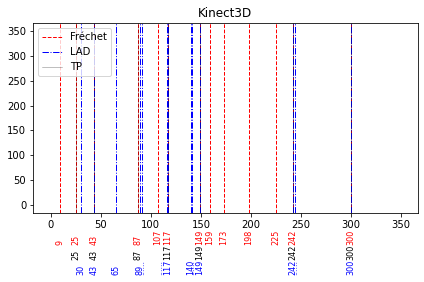

In [155]:
import matplotlib.pyplot as plt

# 创建一些示例数据的图形
plt.plot(range(350), label='Kinect3D Data', linewidth=0)

# 添加垂直线和注释
for x in sorted_Kinect3D:
    plt.axvline(x, color='r', linestyle='--', linewidth=1)
    plt.annotate(f'{x}', (x, 0), textcoords="offset points", xytext=(0, -40),
                     ha='center', va='bottom', color='r', fontsize=8, rotation=90)
'''for i,x in enumerate(list(sorted_Kinect3D)):
    if x == sorted_Kinect3D[-3]:
        plt.annotate('······', (x, 0), textcoords="offset points", xytext=(0, -40),
                     ha='center', va='bottom', color='r', fontsize=8, rotation=90)
    elif x == sorted_Kinect3D[-2]:
        plt.annotate('······', (x, 0), textcoords="offset points", xytext=(0, -40),
                     ha='center', va='bottom', color='w', fontsize=8, rotation=90)    
    else:'''


for x in sorted_LAD:
    plt.axvline(x, color='b', linestyle='-.', linewidth=1)
for i,x in enumerate(list(sorted_LAD)):
    if x == sorted_LAD[4] or x == sorted_LAD[8] or x == sorted_LAD[11]:
        plt.annotate('······', (x, 0), textcoords="offset points", xytext=(3, -70),
                     ha='center', va='bottom', color='b', fontsize=8, rotation=90)
    elif x == sorted_LAD[5]:
        plt.annotate('······', (x, 0), textcoords="offset points", xytext=(-4, -70),
                     ha='center', va='bottom', color='b', fontsize=8, rotation=90)    
    else:
        plt.annotate(f'{x}', (x, 0), textcoords="offset points", xytext=(0, -70),
                     ha='center', va='bottom', color='b', fontsize=8, rotation=90)

for i,x in enumerate([25, 43,87,117,149,242,300]):
    plt.axvline(x, color='k', alpha=0.5, linewidth=0.5)
    plt.annotate(f'{x}', (x, 0), textcoords="offset points", xytext=(0, -55),
                     ha='center', va='bottom', color='k', fontsize=8, rotation=90)

# 添加图例到左上角
plt.legend(handles=[
    plt.Line2D([0], [0], color='r', linestyle='--', linewidth=1, label='Fréchet'),
    plt.Line2D([0], [0], color='b', linestyle='-.', linewidth=1, label='LAD'),
    plt.Line2D([0], [0], color='k', alpha=0.5, linewidth=0.5, label='TP')
], loc='upper left')

plt.title("Kinect3D")

plt.tight_layout()

# 设置保存路径
save_path = '/结果/Kinect3D.svg'

# 保存图形为SVG文件
plt.savefig(save_path, format='svg')

# 显示图形（可选）
plt.show()


# AlphaPose dataset

In [ ]:
AlphaPose_cp = ChangePointDetector(AlphaPose, c=2, alpha=0.01)
AlphaPose_cp.binary_segmentation()
_, cps_LAD_AlphaPose, LAD_list_AlphaPose = LAD(AlphaPose, cps_true=adja_cp.cp_detected, window1=220, window2=110)
print(
    f"Detected (Fréchet): {AlphaPose_cp.cp_detected}; Detected (LAD): {cps_LAD_AlphaPose}"
)

In [ ]:
sorted_AlphaPose = sorted(AlphaPose_cp.cp_detected)
sorted_LAD2 = sorted(cps_LAD_AlphaPose)
print(sorted_AlphaPose)
print(sorted_LAD2)
print([185, 265, 482, 608, 673, 741, 811])

In [ ]:
import matplotlib.pyplot as plt

# 创建一些示例数据的图形
plt.plot(range(1000), label='Alphapose Data', linewidth=0)

# 添加垂直线和注释
for x in sorted_AlphaPose:
    plt.axvline(x, color='r', linestyle='--', linewidth=1)
    
for i,x in enumerate(list(sorted_adja)):
    if x == sorted_AlphaPose[4]:
        plt.annotate('······', (x, 0), textcoords="offset points", xytext=(-3, -40),
                     ha='center', va='bottom', color='r', fontsize=8, rotation=90)
    else:
        plt.annotate(f'{x}', (x, 0), textcoords="offset points", xytext=(0, -40),
                     ha='center', va='bottom', color='r', fontsize=8, rotation=90)
        

for x in sorted_LAD2:
    plt.axvline(x, color='b', linestyle='-.', linewidth=0.2)
for i,x in enumerate(list(sorted_LAD)):
    if x == sorted_LAD2[-1]:
        plt.annotate(f'{x}', (x, 0), textcoords="offset points", xytext=(0, -70),
                     ha='center', va='bottom', color='b', fontsize=8, rotation=90)
    elif x == sorted_LAD2[0]:
        plt.annotate('······', (x, 0), textcoords="offset points", xytext=(0, -70),
                     ha='center', va='bottom', color='b', fontsize=8, rotation=90)

for i,x in enumerate([185, 265, 482, 608, 673, 741, 811]):
    plt.axvline(x, color='k', alpha=0.5, linewidth=0.5)
    plt.annotate(f'{x}', (x, 0), textcoords="offset points", xytext=(0, -55),
                 ha='center', va='bottom', color='k', fontsize=8, rotation=90)

# 添加图例到左上角
plt.legend(handles=[
    plt.Line2D([0], [0], color='r', linestyle='--', linewidth=1, label='Fréchet'),
    plt.Line2D([0], [0], color='b', linestyle='-.', linewidth=0.2, label='LAD'),
    plt.Line2D([0], [0], color='k', alpha=0.5, linewidth=0.5, label='TP')
], loc='upper left')

plt.title("Alphapose")

plt.tight_layout()

# 设置保存路径
save_path = '/结果/2.svg'

# 保存图形为SVG文件
plt.savefig(save_path, format='svg')

# 显示图形（可选）
plt.show()
